In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import tqdm
from einops import rearrange, repeat
import numpy as np
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

from case_studies.dc2_mdt.utils.reverse_markov_learning import RMLDiffusion
from case_studies.dc2_mdt.utils.resample import SigmoidSampler
from case_studies.dc2_mdt.utils.new_simulate_image import ImageSimulator

In [3]:
image_size = 8
max_objects = 2
image_normalize_strategy = "linear_scale"

## RML

In [4]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )  # (1, hidden)
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])  # (1, hidden)
        self.input_embed = nn.Sequential(
            nn.Linear(int(np.prod(data_shape)), hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.cond_embed = nn.Sequential(
            nn.Linear(6, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.image_embed = nn.Sequential(
            nn.Linear(image_size * image_size, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.layers = nn.Sequential(
            nn.Linear(hidden_ch * 3 + int(np.prod(data_shape)), hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, int(np.prod(data_shape))),
        )

    def forward(self, x, t, *, image, cond, epsilon, is_training):
        if is_training:
            t = t.unsqueeze(-1)  # (b, m, 1)
            sin_embed_t = torch.sin(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            cos_embed_t = torch.cos(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            embed_t = self.timestep_embed(
                rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                          "d b m w -> b m (d w)")
            )  # (b, m, hidden)
            embed_xt = self.input_embed(x.flatten(2))  # (b, m, hidden)
            embed_image = self.image_embed(image.flatten(1))  # (b, hidden)
            embed_image = repeat(embed_image, "b hidden -> b m hidden", m=t.shape[1])
            embed_cond = self.cond_embed(cond.flatten(1))  # (b, hidden)
            embed_cond = repeat(embed_cond, "b hidden -> b m hidden", m=t.shape[1])
            out = self.layers(
                torch.cat([embed_xt + embed_t, 
                           embed_cond, 
                           embed_image, 
                           epsilon.flatten(2)], dim=-1)
            )
            return out.view(x.shape)
        t = t.clone()
        image = image.clone()
        t = t.unsqueeze(-1)  # (b, 1)
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )  # (b, hidden)
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(
            rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                      "d b w -> b (d w)")
        )
        embed_xt = self.input_embed(x.flatten(1))
        embed_image = self.image_embed(image.flatten(1))
        embed_cond = self.cond_embed(cond.flatten(1))
        out = self.layers(
            torch.cat([embed_xt + embed_t, 
                       embed_cond, 
                       embed_image, 
                       epsilon.flatten(1)], dim=-1)
        )
        return out.view(x.shape)

In [28]:
device = torch.device("cuda:6")
batch_size = 1024
training_time_steps = 1000
training_iters = 50_000
ddim_steps = 3
ddim_eta = 0.0  # use 0.0 for better results when max_objects >= 2
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [6]:
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 psf_stdev=1.0,
                                 flux_alpha=10.0,
                                 flux_beta=0.01,
                                 pad=0,
                                 always_max_count=False,
                                 constant_locs=False,
                                 coadd_images=True).to(device=device)

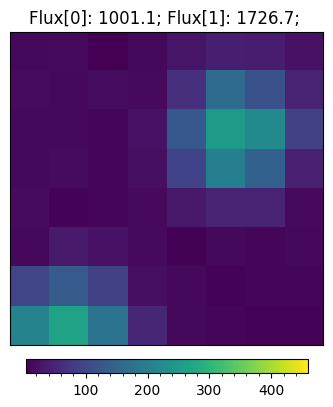

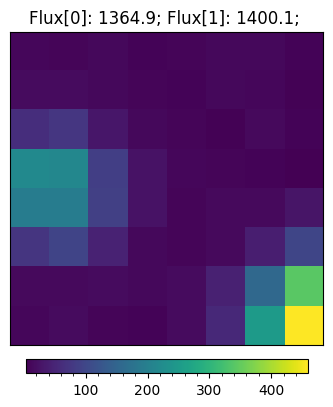

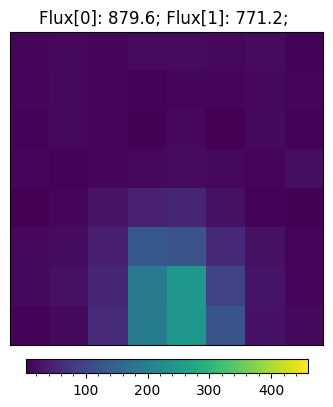

In [7]:
sim_out = image_simulator.generate(3, seed=7272)
img_min = sim_out["images"].min()
img_max = sim_out["images"].max()
for sub_img, flux in zip(sim_out["images"], sim_out["fluxes"]):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    im = ax.imshow(sub_img.cpu(), vmin=img_min, vmax=img_max)
    ax.set_xticks([])
    ax.set_yticks([])
    if flux.shape[0] == 1:
        ax.set_title(f"Flux: {flux.item():.1f}")
    else:
        t = ""
        for i, f in enumerate(flux):
            t += f"Flux[{i}]: {f.item():.1f}; "
        ax.set_title(t)
    cb = fig.colorbar(im, ax=ax, 
                      location="bottom", shrink=0.6,
                      anchor=(0.5, 2.0))
    cb.minorticks_on()
    fig.tight_layout()
    fig.show()

In [29]:
training_diffusion = RMLDiffusion(num_timesteps=training_time_steps,
                                  num_sampling_steps=ddim_steps,
                                  m=16,
                                  lambda_=1.0,
                                  beta=0.5)
sampling_diffusion = training_diffusion
# schedule_sampler = create_named_schedule_sampler("uniform", training_diffusion)
# schedule_sampler = SpeedSampler(diffusion=training_diffusion,
#                                 lam=0.6,
#                                 k=5,
#                                 tau=700)
schedule_sampler = SigmoidSampler(training_diffusion, 0)

In [9]:
my_net = FourierMLP(data_shape=[2, 1], 
                    num_layers=8, 
                    hidden_ch=64).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [10]:
# max_flux_boundary = 2000.0
# def encode_flux(flux: torch.Tensor):
#     assert flux.min() >= 0.0
#     flux = flux.clamp(max=max_flux_boundary)
#     return (torch.log1p(flux) / torch.log1p(torch.tensor(max_flux_boundary))) * 2 - 1

# def decode_flux(flux_minus1_to_1: torch.Tensor):
#     assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
#     return torch.expm1((flux_minus1_to_1 + 1) / 2 * torch.log1p(torch.tensor(max_flux_boundary)))

In [11]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    flux = flux.clamp(max=max_flux_boundary)
    return (flux / max_flux_boundary) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return (flux_minus1_to_1 + 1) / 2 * max_flux_boundary

In [12]:
def encode_x_start(catalog):
    n_sources = catalog["counts"]  # (b, )
    locs = catalog["locs"]  # (b, m, 2)
    fluxes = catalog["fluxes"].unsqueeze(-1)  # (b, m, 1)
    n_sources = (n_sources.unsqueeze(-1) >= torch.arange(1, locs.shape[1] + 1, device=locs.device)).unsqueeze(-1)  # (b, m, 1)
    x_start = torch.cat([n_sources * 2 - 1, locs / image_size * 2 - 1, encode_flux(fluxes)], dim=-1)  # (b, m, 4)
    sorted_index = x_start[..., -1].argsort(dim=-1, descending=True)  # (b, m)
    return torch.take_along_dim(x_start, repeat(sorted_index, "... -> ... r", r=4), dim=-2)  # (b, m, 4)

In [13]:
def decode_x_start(output_x_start):
    n_sources = output_x_start[..., 0] > 0.0  # (b, m)
    locs = (output_x_start[..., 1:3] + 1) / 2 * image_size  # (b, m, 2)
    fluxes = decode_flux(output_x_start[..., 3])  # (b, m)
    return {
        "counts": n_sources.sum(dim=-1),
        "n_sources": n_sources.int(),
        "locs": locs,
        "fluxes": fluxes,
    }

In [14]:
def normalize_image(input_image):
    match image_normalize_strategy:
        case "none":
            output_image = input_image
        case "log":
            output_image = torch.log1p(input_image)
        case "linear_scale":
            output_image = input_image / 1000
        case _:
            raise NotImplementedError()
    return output_image

In [15]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    t, batch_sample_weights, batch_loss_weights = schedule_sampler.sample(batch_size, device=device)
    input_image = catalog["images"]  # (b, h, w)
    input_image = normalize_image(input_image)
    cond, x_start = encode_x_start(catalog).split([3, 1], dim=-1)
    train_loss_args = {
        "model": my_net,
        "x_start": x_start,
        "t": t,
        "loss_weights": batch_loss_weights
    }
    loss = training_diffusion.training_losses(**train_loss_args, 
                                              model_kwargs={"image": input_image,
                                                            "cond": cond})["loss"]
    loss = (loss * batch_sample_weights).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

  1%|          | 507/50000 [00:10<16:53, 48.82it/s]

[500/50000] loss: 8.933e-02


  2%|▏         | 1006/50000 [00:20<16:22, 49.87it/s]

[1000/50000] loss: 6.790e-02


  3%|▎         | 1509/50000 [00:30<16:12, 49.84it/s]

[1500/50000] loss: 6.610e-02


  4%|▍         | 2006/50000 [00:40<15:53, 50.36it/s]

[2000/50000] loss: 5.884e-02


  5%|▌         | 2508/50000 [00:50<16:30, 47.96it/s]

[2500/50000] loss: 5.767e-02


  6%|▌         | 3009/50000 [01:00<15:29, 50.58it/s]

[3000/50000] loss: 6.701e-02


  7%|▋         | 3509/50000 [01:10<15:52, 48.80it/s]

[3500/50000] loss: 5.595e-02


  8%|▊         | 4008/50000 [01:20<15:08, 50.62it/s]

[4000/50000] loss: 5.679e-02


  9%|▉         | 4506/50000 [01:30<15:05, 50.25it/s]

[4500/50000] loss: 5.622e-02


 10%|█         | 5005/50000 [01:40<15:16, 49.10it/s]

[5000/50000] loss: 5.634e-02


 11%|█         | 5509/50000 [01:51<15:05, 49.13it/s]

[5500/50000] loss: 5.574e-02


 12%|█▏        | 6007/50000 [02:00<14:50, 49.38it/s]

[6000/50000] loss: 5.403e-02


 13%|█▎        | 6510/50000 [02:11<14:33, 49.78it/s]

[6500/50000] loss: 5.873e-02


 14%|█▍        | 7007/50000 [02:20<14:29, 49.47it/s]

[7000/50000] loss: 5.551e-02


 15%|█▌        | 7506/50000 [02:30<14:20, 49.36it/s]

[7500/50000] loss: 5.167e-02


 16%|█▌        | 8007/50000 [02:40<14:15, 49.06it/s]

[8000/50000] loss: 5.695e-02


 17%|█▋        | 8505/50000 [02:50<13:53, 49.80it/s]

[8500/50000] loss: 5.540e-02


 18%|█▊        | 9007/50000 [03:00<13:49, 49.44it/s]

[9000/50000] loss: 5.335e-02


 19%|█▉        | 9508/50000 [03:10<13:22, 50.44it/s]

[9500/50000] loss: 5.831e-02


 20%|██        | 10010/50000 [03:20<13:26, 49.58it/s]

[10000/50000] loss: 5.334e-02


 21%|██        | 10508/50000 [03:30<13:03, 50.43it/s]

[10500/50000] loss: 5.687e-02


 22%|██▏       | 11010/50000 [03:40<12:54, 50.33it/s]

[11000/50000] loss: 5.444e-02


 23%|██▎       | 11509/50000 [03:50<12:58, 49.47it/s]

[11500/50000] loss: 5.354e-02


 24%|██▍       | 12010/50000 [04:00<12:41, 49.92it/s]

[12000/50000] loss: 5.550e-02


 25%|██▌       | 12509/50000 [04:10<12:22, 50.49it/s]

[12500/50000] loss: 5.176e-02


 26%|██▌       | 13006/50000 [04:20<12:34, 49.04it/s]

[13000/50000] loss: 4.951e-02


 27%|██▋       | 13507/50000 [04:30<11:40, 52.13it/s]

[13500/50000] loss: 5.205e-02


 28%|██▊       | 14006/50000 [04:39<10:47, 55.60it/s]

[14000/50000] loss: 5.272e-02


 29%|██▉       | 14508/50000 [04:49<10:44, 55.05it/s]

[14500/50000] loss: 5.551e-02


 30%|███       | 15006/50000 [04:59<11:30, 50.68it/s]

[15000/50000] loss: 4.901e-02


 31%|███       | 15509/50000 [05:09<11:17, 50.89it/s]

[15500/50000] loss: 5.047e-02


 32%|███▏      | 16007/50000 [05:18<11:15, 50.31it/s]

[16000/50000] loss: 5.342e-02


 33%|███▎      | 16509/50000 [05:28<10:19, 54.10it/s]

[16500/50000] loss: 5.525e-02


 34%|███▍      | 17009/50000 [05:38<10:59, 50.01it/s]

[17000/50000] loss: 5.161e-02


 35%|███▌      | 17507/50000 [05:48<10:47, 50.14it/s]

[17500/50000] loss: 5.154e-02


 36%|███▌      | 18010/50000 [05:58<10:31, 50.67it/s]

[18000/50000] loss: 4.706e-02


 37%|███▋      | 18508/50000 [06:08<10:19, 50.83it/s]

[18500/50000] loss: 5.342e-02


 38%|███▊      | 19006/50000 [06:18<10:11, 50.71it/s]

[19000/50000] loss: 5.340e-02


 39%|███▉      | 19507/50000 [06:28<10:00, 50.76it/s]

[19500/50000] loss: 5.555e-02


 40%|████      | 20008/50000 [06:38<09:45, 51.26it/s]

[20000/50000] loss: 5.402e-02


 41%|████      | 20505/50000 [06:48<09:47, 50.19it/s]

[20500/50000] loss: 5.366e-02


 42%|████▏     | 21007/50000 [06:58<09:37, 50.20it/s]

[21000/50000] loss: 5.266e-02


 43%|████▎     | 21505/50000 [07:07<09:22, 50.66it/s]

[21500/50000] loss: 5.271e-02


 44%|████▍     | 22009/50000 [07:17<09:13, 50.61it/s]

[22000/50000] loss: 5.190e-02


 45%|████▌     | 22508/50000 [07:27<09:00, 50.88it/s]

[22500/50000] loss: 5.296e-02


 46%|████▌     | 23006/50000 [07:37<08:50, 50.89it/s]

[23000/50000] loss: 5.181e-02


 47%|████▋     | 23510/50000 [07:47<08:43, 50.56it/s]

[23500/50000] loss: 5.133e-02


 48%|████▊     | 24007/50000 [07:57<08:34, 50.55it/s]

[24000/50000] loss: 5.519e-02


 49%|████▉     | 24505/50000 [08:06<08:25, 50.44it/s]

[24500/50000] loss: 5.065e-02


 50%|█████     | 25010/50000 [08:16<08:11, 50.86it/s]

[25000/50000] loss: 5.455e-02


 51%|█████     | 25509/50000 [08:26<08:06, 50.36it/s]

[25500/50000] loss: 4.969e-02


 52%|█████▏    | 26007/50000 [08:36<07:59, 50.09it/s]

[26000/50000] loss: 5.269e-02


 53%|█████▎    | 26506/50000 [08:46<07:41, 50.91it/s]

[26500/50000] loss: 4.978e-02


 54%|█████▍    | 27010/50000 [08:56<07:39, 50.02it/s]

[27000/50000] loss: 5.131e-02


 55%|█████▌    | 27510/50000 [09:05<07:27, 50.26it/s]

[27500/50000] loss: 4.982e-02


 56%|█████▌    | 28005/50000 [09:15<07:05, 51.70it/s]

[28000/50000] loss: 5.217e-02


 57%|█████▋    | 28506/50000 [09:24<06:29, 55.24it/s]

[28500/50000] loss: 5.290e-02


 58%|█████▊    | 29009/50000 [09:34<06:56, 50.36it/s]

[29000/50000] loss: 5.236e-02


 59%|█████▉    | 29508/50000 [09:44<06:42, 50.88it/s]

[29500/50000] loss: 5.478e-02


 60%|██████    | 30006/50000 [09:53<06:38, 50.12it/s]

[30000/50000] loss: 4.957e-02


 61%|██████    | 30510/50000 [10:03<06:25, 50.56it/s]

[30500/50000] loss: 5.637e-02


 62%|██████▏   | 31008/50000 [10:13<06:16, 50.48it/s]

[31000/50000] loss: 4.856e-02


 63%|██████▎   | 31509/50000 [10:23<06:01, 51.11it/s]

[31500/50000] loss: 5.007e-02


 64%|██████▍   | 32006/50000 [10:33<05:54, 50.77it/s]

[32000/50000] loss: 4.826e-02


 65%|██████▌   | 32510/50000 [10:43<05:45, 50.60it/s]

[32500/50000] loss: 5.135e-02


 66%|██████▌   | 33010/50000 [10:53<05:34, 50.79it/s]

[33000/50000] loss: 5.000e-02


 67%|██████▋   | 33508/50000 [11:03<05:26, 50.55it/s]

[33500/50000] loss: 4.972e-02


 68%|██████▊   | 34006/50000 [11:12<05:16, 50.60it/s]

[34000/50000] loss: 5.332e-02


 69%|██████▉   | 34505/50000 [11:22<05:08, 50.16it/s]

[34500/50000] loss: 4.994e-02


 70%|███████   | 35007/50000 [11:32<04:54, 50.85it/s]

[35000/50000] loss: 4.970e-02


 71%|███████   | 35505/50000 [11:42<04:43, 51.19it/s]

[35500/50000] loss: 4.697e-02


 72%|███████▏  | 36009/50000 [11:52<04:36, 50.53it/s]

[36000/50000] loss: 4.853e-02


 73%|███████▎  | 36507/50000 [12:02<04:25, 50.73it/s]

[36500/50000] loss: 4.657e-02


 74%|███████▍  | 37005/50000 [12:11<04:16, 50.57it/s]

[37000/50000] loss: 4.906e-02


 75%|███████▌  | 37509/50000 [12:21<04:03, 51.20it/s]

[37500/50000] loss: 4.953e-02


 76%|███████▌  | 38008/50000 [12:31<03:35, 55.65it/s]

[38000/50000] loss: 4.705e-02


 77%|███████▋  | 38506/50000 [12:41<03:45, 51.01it/s]

[38500/50000] loss: 4.725e-02


 78%|███████▊  | 39010/50000 [12:51<03:35, 50.89it/s]

[39000/50000] loss: 4.669e-02


 79%|███████▉  | 39508/50000 [13:00<03:26, 50.77it/s]

[39500/50000] loss: 4.994e-02


 80%|████████  | 40006/50000 [13:10<03:16, 50.85it/s]

[40000/50000] loss: 4.754e-02


 81%|████████  | 40510/50000 [13:20<03:06, 50.96it/s]

[40500/50000] loss: 4.740e-02


 82%|████████▏ | 41008/50000 [13:30<02:57, 50.72it/s]

[41000/50000] loss: 4.713e-02


 83%|████████▎ | 41506/50000 [13:39<02:46, 51.02it/s]

[41500/50000] loss: 4.859e-02


 84%|████████▍ | 42010/50000 [13:49<02:36, 51.12it/s]

[42000/50000] loss: 4.928e-02


 85%|████████▌ | 42508/50000 [13:59<02:27, 50.85it/s]

[42500/50000] loss: 4.728e-02


 86%|████████▌ | 43006/50000 [14:09<02:16, 51.12it/s]

[43000/50000] loss: 4.593e-02


 87%|████████▋ | 43510/50000 [14:19<02:07, 50.74it/s]

[43500/50000] loss: 4.811e-02


 88%|████████▊ | 44008/50000 [14:29<01:57, 50.81it/s]

[44000/50000] loss: 4.787e-02


 89%|████████▉ | 44506/50000 [14:38<01:47, 51.18it/s]

[44500/50000] loss: 4.671e-02


 90%|█████████ | 45010/50000 [14:48<01:37, 51.17it/s]

[45000/50000] loss: 4.742e-02


 91%|█████████ | 45508/50000 [14:58<01:28, 51.03it/s]

[45500/50000] loss: 4.832e-02


 92%|█████████▏| 46006/50000 [15:08<01:18, 51.07it/s]

[46000/50000] loss: 5.009e-02


 93%|█████████▎| 46510/50000 [15:18<01:08, 50.93it/s]

[46500/50000] loss: 4.578e-02


 94%|█████████▍| 47008/50000 [15:27<00:58, 51.07it/s]

[47000/50000] loss: 4.557e-02


 95%|█████████▌| 47506/50000 [15:37<00:49, 50.65it/s]

[47500/50000] loss: 4.844e-02


 96%|█████████▌| 48010/50000 [15:47<00:38, 51.15it/s]

[48000/50000] loss: 4.497e-02


 97%|█████████▋| 48508/50000 [15:57<00:29, 50.98it/s]

[48500/50000] loss: 4.784e-02


 98%|█████████▊| 49006/50000 [16:07<00:19, 51.17it/s]

[49000/50000] loss: 4.513e-02


 99%|█████████▉| 49510/50000 [16:16<00:09, 50.34it/s]

[49500/50000] loss: 4.738e-02


100%|██████████| 50000/50000 [16:26<00:00, 50.68it/s]

[50000/50000] loss: 4.765e-02


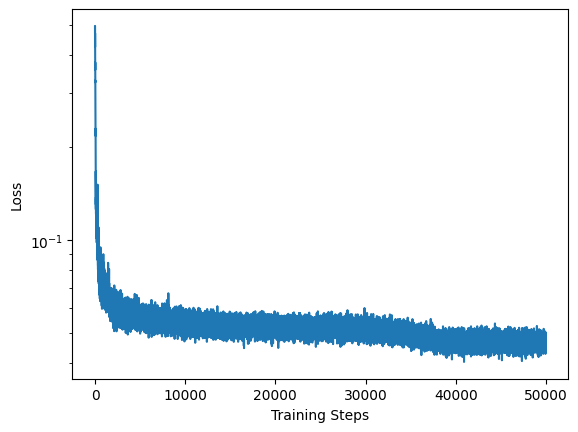

In [16]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [30]:
my_net.eval()
val_true_cat = []
val_est_cat = []
with torch.inference_mode():
    for i in tqdm.tqdm(list(range(1000))):
        val_catalog = image_simulator.generate(batch_size=1024)
        input_image = normalize_image(val_catalog["images"])
        val_catalog = decode_x_start(encode_x_start(val_catalog))
        val_true_cat.append(move_data_to_device(val_catalog, "cpu"))
        cond, x_start = encode_x_start(val_catalog).split([3, 1], dim=-1)
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (1024, max_objects, 1),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image,
                             "cond": cond}
        }
        sample = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, eta=ddim_eta)
        val_est_cat.append(move_data_to_device(
            decode_x_start(torch.cat([cond, sample], dim=-1)), 
        "cpu"))

100%|██████████| 1000/1000 [00:08<00:00, 121.68it/s]


In [31]:
diffusion_pred_ns = []
diffusion_true_ns = []
diffusion_pred_locs = []
diffusion_true_locs = []
diffusion_pred_fluxes = []
diffusion_true_fluxes = []
for ec, tc in zip(val_est_cat, val_true_cat, strict=True):
    diffusion_pred_ns.append(ec["n_sources"])
    diffusion_true_ns.append(tc["n_sources"])
    diffusion_pred_locs.append(ec["locs"])
    diffusion_true_locs.append(tc["locs"])
    diffusion_pred_fluxes.append(ec["fluxes"])
    diffusion_true_fluxes.append(tc["fluxes"])
diffusion_pred_ns = torch.cat(diffusion_pred_ns, dim=0)
diffusion_true_ns = torch.cat(diffusion_true_ns, dim=0)
diffusion_pred_locs = torch.cat(diffusion_pred_locs, dim=0)
diffusion_true_locs = torch.cat(diffusion_true_locs, dim=0)
diffusion_pred_fluxes = torch.cat(diffusion_pred_fluxes, dim=0)
diffusion_true_fluxes = torch.cat(diffusion_true_fluxes, dim=0)

In [32]:
diffusion_true_ns.shape, diffusion_pred_ns.shape

(torch.Size([1024000, 2]), torch.Size([1024000, 2]))

In [33]:
diffusion_pred_locs.shape, diffusion_true_locs.shape

(torch.Size([1024000, 2, 2]), torch.Size([1024000, 2, 2]))

In [34]:
diffusion_pred_fluxes.shape, diffusion_true_fluxes.shape

(torch.Size([1024000, 2]), torch.Size([1024000, 2]))

In [35]:
def plot_cm(d_pred_bin_index, d_true_bin_index, bin_num, bin_labels, axis_label):
    d_cm = torch.zeros(bin_num, bin_num, dtype=torch.int)
    for ri in range(d_cm.shape[0]):
        for ci in range(d_cm.shape[1]):
            d_cm[ri, ci] = ((d_pred_bin_index == ri) & (d_true_bin_index == ci)).sum()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt="d", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=ax)
    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Pred {axis_label}")
    ax.set_title("Diffusion")
    fig.show()

    # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
    #             annot=True,
    #             fmt=".2f", cmap="Greens", cbar=False,
    #             xticklabels=bin_labels,
    #             yticklabels=bin_labels,
    #             ax=ax)
    # ax.set_xlabel(f"True {axis_label}")
    # ax.set_ylabel(f"Pred {axis_label}")
    # ax.set_title("Diffusion (CM in Percent)")
    # fig.show()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1)).abs(),
                annot=(d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
                fmt=".2f", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=ax)
    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Pred {axis_label}")
    ax.set_title("Diffusion (Asymmetry Factor)")
    fig.show()

In [36]:
def inclusive_bucektize(input_t, boundary):
    new_boundary = boundary.clone()
    new_boundary[0] -= 1e-3
    new_boundary[-1] += 1e-3
    b_index = torch.bucketize(input_t, new_boundary)
    assert (b_index > 0).all()
    assert (b_index < new_boundary.shape[0]).all()
    return b_index - 1

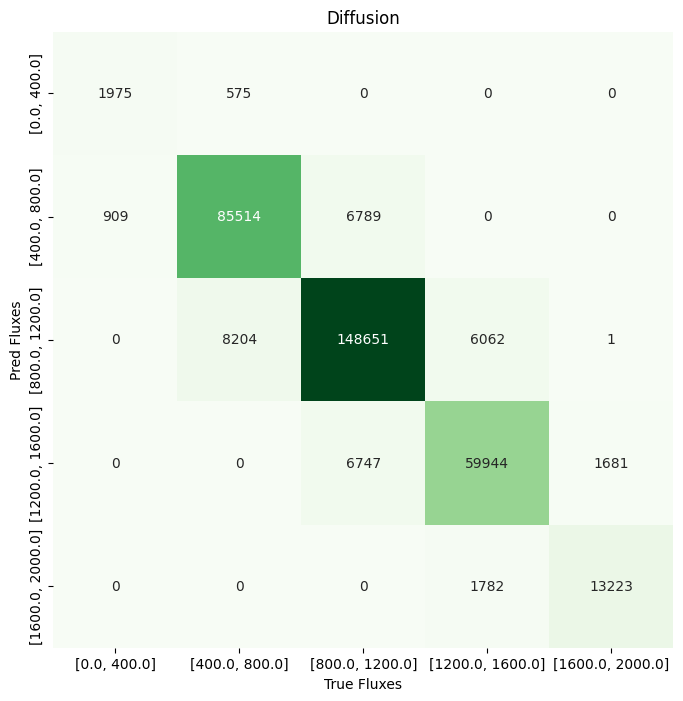

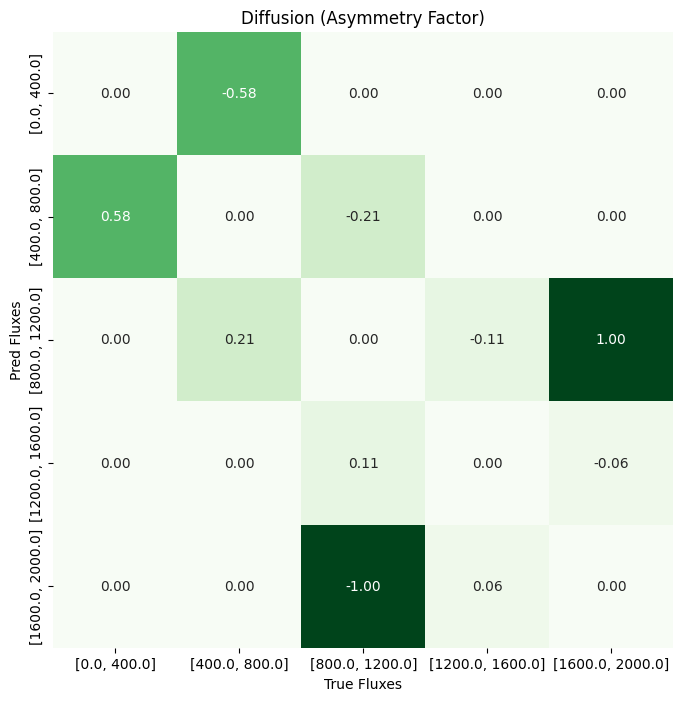

In [37]:
fluxes_bin_boundary = torch.linspace(0.0, 2000.0, 6)
only_one_source_mask = ((diffusion_pred_ns.sum(dim=-1) == 1) & (diffusion_true_ns.sum(dim=-1) == 1)).unsqueeze(-1)
d_pred_fluxes_bin_index = inclusive_bucektize(diffusion_pred_fluxes[only_one_source_mask & diffusion_pred_ns.bool()], 
                                              fluxes_bin_boundary)
d_true_fluxes_bin_index = inclusive_bucektize(diffusion_true_fluxes[only_one_source_mask & diffusion_true_ns.bool()], 
                                              fluxes_bin_boundary)
plot_cm(d_pred_fluxes_bin_index, d_true_fluxes_bin_index, 
        bin_num=5, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(fluxes_bin_boundary[:-1], 
                                                   fluxes_bin_boundary[1:])], 
        axis_label="Fluxes")

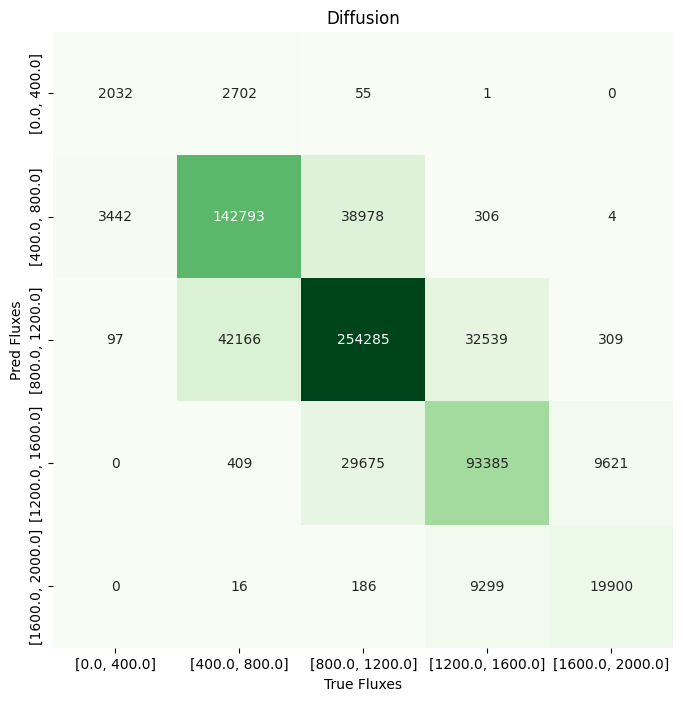

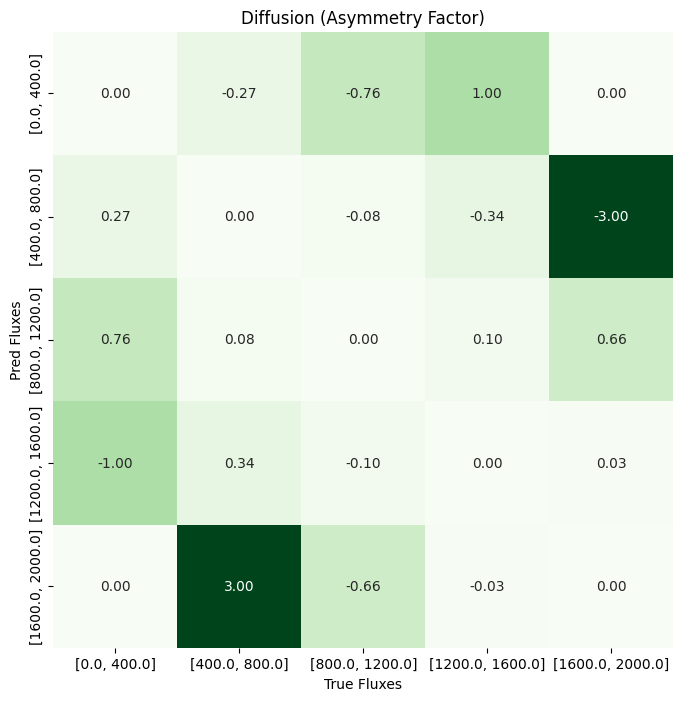

In [38]:
fluxes_bin_boundary = torch.linspace(0.0, 2000.0, 6)
only_two_source_mask = ((diffusion_pred_ns.sum(dim=-1) == 2) & (diffusion_true_ns.sum(dim=-1) == 2)).unsqueeze(-1)
d_pred_fluxes_bin_index = inclusive_bucektize(diffusion_pred_fluxes[only_two_source_mask & diffusion_pred_ns.bool()], 
                                              fluxes_bin_boundary)
d_true_fluxes_bin_index = inclusive_bucektize(diffusion_true_fluxes[only_two_source_mask & diffusion_true_ns.bool()], 
                                              fluxes_bin_boundary)
plot_cm(d_pred_fluxes_bin_index, d_true_fluxes_bin_index, 
        bin_num=5, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(fluxes_bin_boundary[:-1], 
                                                   fluxes_bin_boundary[1:])], 
        axis_label="Fluxes")

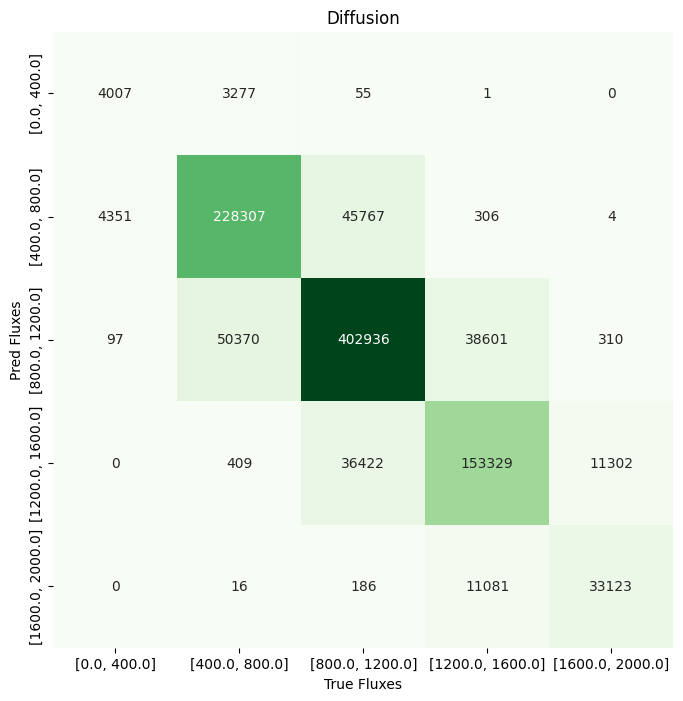

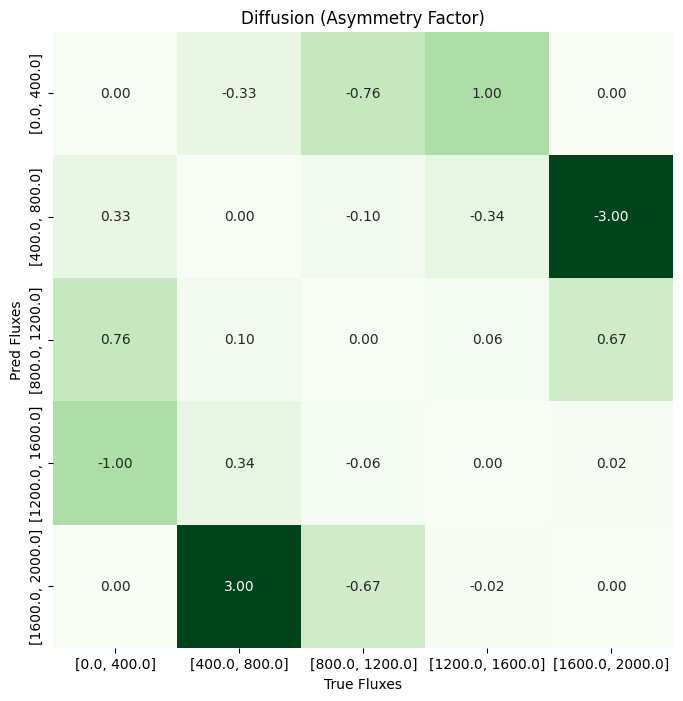

In [39]:
fluxes_bin_boundary = torch.linspace(0.0, 2000.0, 6)
d_pred_fluxes_bin_index = inclusive_bucektize(diffusion_pred_fluxes[diffusion_pred_ns.bool()], fluxes_bin_boundary)
d_true_fluxes_bin_index = inclusive_bucektize(diffusion_true_fluxes[diffusion_true_ns.bool()], fluxes_bin_boundary)
plot_cm(d_pred_fluxes_bin_index, d_true_fluxes_bin_index, 
        bin_num=5, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(fluxes_bin_boundary[:-1], 
                                                   fluxes_bin_boundary[1:])], 
        axis_label="Fluxes")

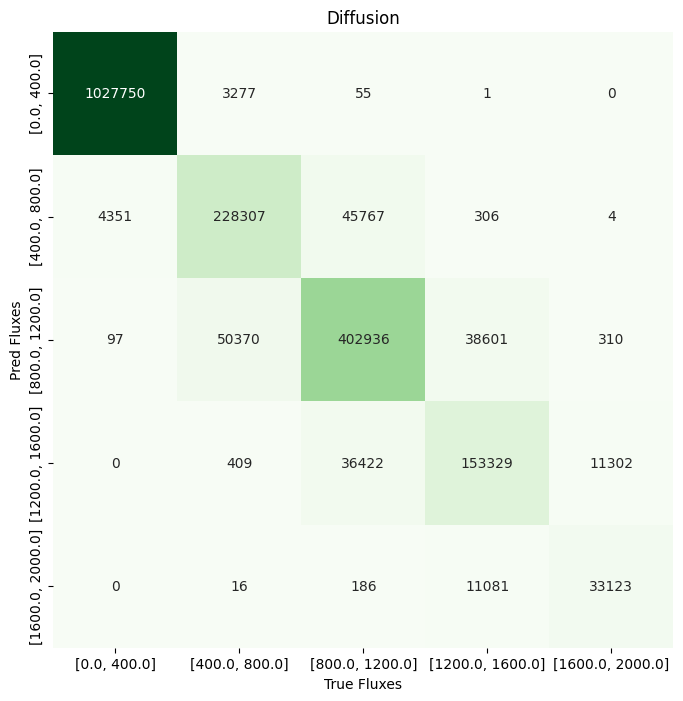

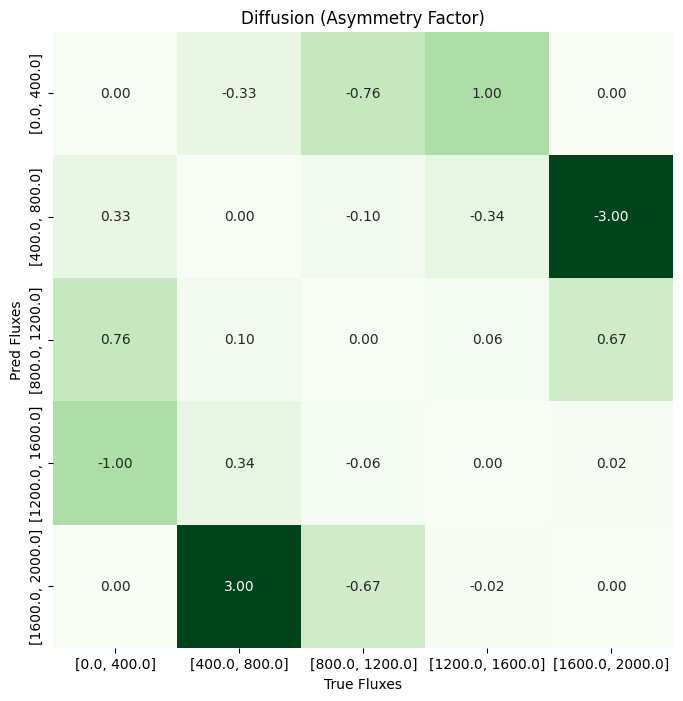

In [40]:
fluxes_bin_boundary = torch.linspace(0.0, 2000.0, 6)
d_pred_fluxes_bin_index = inclusive_bucektize(diffusion_pred_fluxes, fluxes_bin_boundary)
d_true_fluxes_bin_index = inclusive_bucektize(diffusion_true_fluxes, fluxes_bin_boundary)
plot_cm(d_pred_fluxes_bin_index, d_true_fluxes_bin_index, 
        bin_num=5, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(fluxes_bin_boundary[:-1], 
                                                   fluxes_bin_boundary[1:])], 
        axis_label="Fluxes")